# Test different facet sizes and see how they compare

In [1]:
import sys
sys.path.append("../")

from surface import *
from source import *
from simulator import *

import numpy as np
from time import time as Time

## Define Surfaces

In [11]:
# tuple with facet sizes
fss = (20, 10, 5, 3, 2)

# do not overlap facets at all
overlap = 0 # percentage for facets to overlap

# compute dimensions based on facet size
ftprnt_size = 2000 # footprint width [m]
dimss = [(int(ftprnt_size/fs),int(ftprnt_size/fs)) for fs in fss]

# origin
origin = (4000, 4000)

In [12]:
# generate a list of surfaces to call
surfs = [Surface(origin=origin, dims=d, fs=fs, overlap=overlap) for d, fs in zip(dimss, fss)]
for s in surfs:
    s.gen_flat(0)

## Generate Orbit/Sources

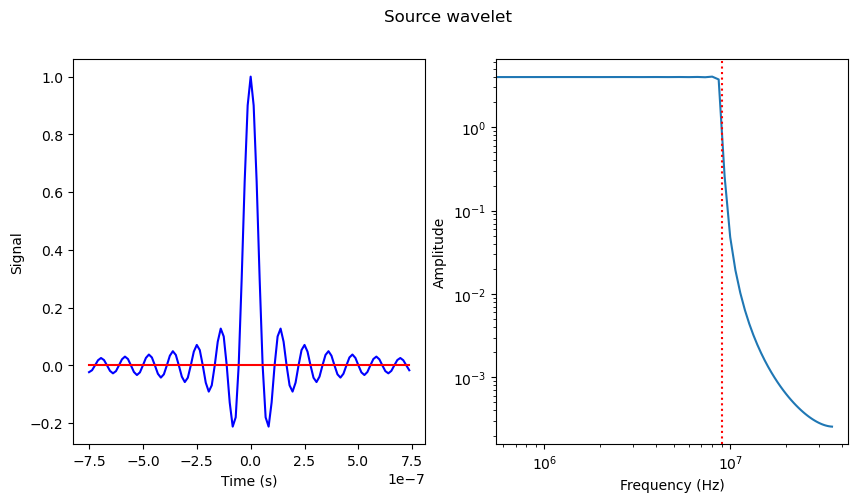

In [13]:
f0  = 9e6             # center frequency [Hz]
dt  = 1 / (8 * f0)    # time delta to avoid aliasing [s]
dur = 0.5e-6          # how long to make source chirp [s]
sy  = 5050            # source y [m]
sz  = 25000           # source z [m] - this is like orbital altitude

# source list
ss = []
# how many sources to place in transit?
n = 100 
for x in np.linspace(0, 10000, n):
    source = Source(dt, dur, (x, sy, sz))
    source.chirp(f0, 1e6)
    ss.append(source)
source.plot()

In [14]:
## Point target location
tx = 5000 # target x [m]
ty = 5050 # target y [m]
tz = -385 # target z [m]

## Define tx/rx window

In [15]:
start = 166.8e-6 # [s]
end   = 177e-6   # [s]
# how many time samples?
nt = int((end-start)/dt)
# gen time axis
ts = np.linspace(start, end, nt)

## Simulate

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [17]:

# do not simulate surface reflection
reflect = False
# output array to house radar images
rdrgrms = []
# for focusing
pathtimes = []
# system start time
st = Time()

# iterate through facet sizes
for i, surf in enumerate(surfs):

    # clock
    st_fs = Time()

    # generate empty array to fill
    rdrgrm = np.zeros((nt, n), np.complex128)

    # array which contains pathtimes to target for focusing
    pathtime = []

    # simulate
    print(f"Simulating at facet size: {fss[i]:03d} m | dims: {dimss[i][0]:03d}x{dimss[i][0]:03d}")

    # iterate through sources in transit
    for j, s in enumerate(ss):
        print(f"Simulating: {j+1}/{len(ss)} ({round(100*((j+1)/len(ss)), 1)}%)", end="     \r")
        model = Model(surf, s, reflect=reflect, vec=True)
        model.set_target((tx, ty, tz))
        model.gen_raypaths()
        #model.comp_dopplers()
        model.gen_timeseries_vec(show=False, doppler=False)
        rdrgrm[:,j] += np.interp(ts, model.ts, np.real(model.signal))
        rdrgrm[:,j] += 1j * np.interp(ts, model.ts, np.imag(model.signal))
        # center facet index
        #cid = len(model.raypaths) // 2
        # append travel time to pathtimes
        pathtime.append(model.path_time[dimss[i][0]//2, dimss[i][1]//2])
        
    print(f"\nProcessing time for fs of {fss[i]:03d} m : {round((Time() - st_fs)/60)} minutes and {round((Time() - st_fs) % 60,2)} seconds")

    # add to radargram list
    rdrgrms.append(rdrgrm)
    # add pathtimes
    pathtimes.append(pathtime)

print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating at facet size: 020 m | dims: 100x100
Simulating: 100/100 (100.0%)     
Processing time for fs of 020 m : 0 minutes and 2.39 seconds
Simulating at facet size: 010 m | dims: 200x200
Simulating: 100/100 (100.0%)     
Processing time for fs of 010 m : 0 minutes and 10.17 seconds
Simulating at facet size: 005 m | dims: 400x400
Simulating: 100/100 (100.0%)     
Processing time for fs of 005 m : 1 minutes and 39.98 seconds
Simulating at facet size: 003 m | dims: 666x666
Simulating: 100/100 (100.0%)     
Processing time for fs of 003 m : 2 minutes and 52.96 seconds
Simulating at facet size: 002 m | dims: 1000x1000
Simulating: 100/100 (100.0%)     
Processing time for fs of 002 m : 4 minutes and 14.51 seconds


Total processing time: 7 minutes and 0.01 seconds


In [ ]:
# do not simulate surface reflection
reflect = False
# output array to house radar images
rdrgrms = []
# for focusing
pathtimes = []
# system start time
st = Time()

# iterate through facet sizes
for i, surf in enumerate(surfs):

    # clock
    st_fs = Time()

    # generate empty array to fill
    rdrgrm = np.zeros((nt, n), np.complex128)

    # Preallocate path time list with None placeholders
    pathtime = [None] * len(ss)

    # simulate
    print(f"Simulating at facet size: {fss[i]:03d} m | dims: {dimss[i][0]:03d}x{dimss[i][0]:03d}")

    def process_source(j, s):
        model = Model(surf, s, reflect=reflect, vec=True)
        model.set_target((tx, ty, tz))
        model.gen_raypaths()
        model.comp_dopplers()
        model.gen_timeseries(show=False)
        signal_real = np.interp(ts, model.ts, np.real(model.signal))
        signal_imag = np.interp(ts, model.ts, np.imag(model.signal))
        # center facet index
        cid = len(model.raypaths) // 2
        path_time = model.raypaths[cid].path_time
        return j, signal_real, signal_imag, path_time

    # Multithreading processing
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_source, j, s): j for j, s in enumerate(ss)}
        for future in as_completed(futures):
            j, signal_real, signal_imag, path_time = future.result()
            rdrgrm[:, j] = signal_real + 1j * signal_imag  # Direct assignment to ensure order
            pathtime[j] = path_time  # Store in correct order
            print(f"Simulating: {j+1}/{len(ss)} ({round(100*((j+1)/len(ss)), 1)}%)", end="     \r")

    print(f"\nProcessing time for fs of {fss[i]:03d} m : {round((Time() - st_fs)/60)} minutes and {round((Time() - st_fs) % 60,2)} seconds")

    # add to radargram list
    rdrgrms.append(rdrgrm)
    # add pathtimes
    pathtimes.append(pathtime)

print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating at facet size: 020 m | dims: 100x100
Simulating: 100/100 (100.0%)     
Processing time for fs of 020 m : 3 minutes and 9.46 seconds
Simulating at facet size: 010 m | dims: 200x200
Simulating: 100/100 (100.0%)     
Processing time for fs of 010 m : 13 minutes and 36.06 seconds
Simulating at facet size: 005 m | dims: 400x400
Simulating: 98/100 (98.0%)        
Processing time for fs of 005 m : 51 minutes and 54.98 seconds
Simulating at facet size: 003 m | dims: 666x666
Simulating: 98/100 (98.0%)                                 
Processing time for fs of 003 m : 141 minutes and 17.95 seconds
Simulating at facet size: 002 m | dims: 1000x1000


In [18]:
# export the radar data
np.save("variable_fs", np.array(rdrgrms))

## View and focus each

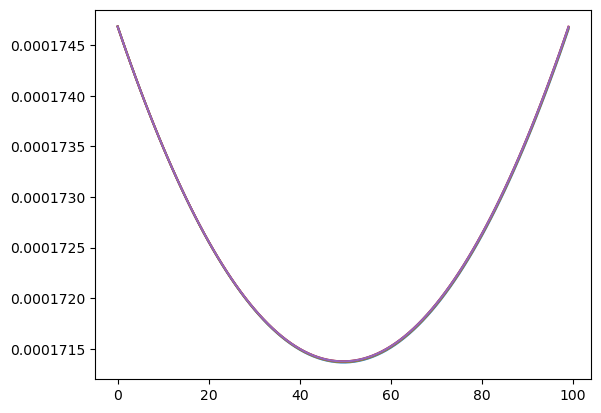

In [19]:
for i, p in enumerate(pathtimes):
    plt.plot(range(100), p, label=fss[i])
plt.show()

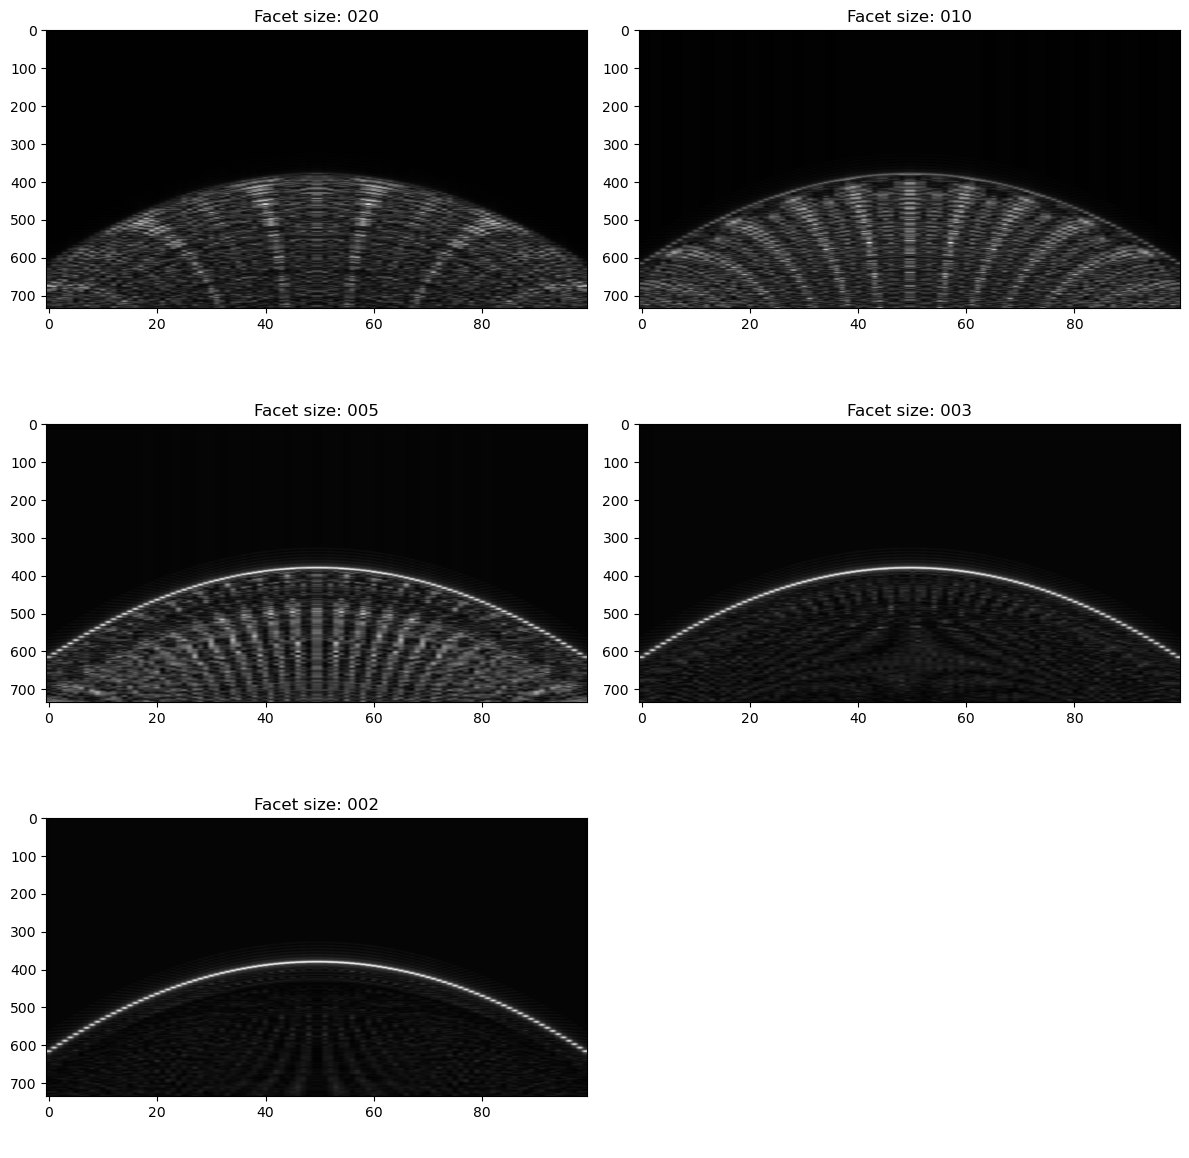

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.flatten()
for i, rdr in enumerate(rdrgrms):
    ax[i].imshow(np.abs(rdr), cmap="grey", aspect=0.07)
    ax[i].set_title(f"Facet size: {fss[i]:03d}")
ax[-1].axis("off")
plt.tight_layout()
plt.savefig("VariableFsUnfocused.png")
plt.show()

In [22]:
rngbins = []
# compute range bin offset
for pathtime in pathtimes:
    rngbin = (np.array(pathtime) - start) // dt
    rngbin -= np.min(rngbin)
    rngbins.append(rngbin)

In [23]:
def focus_pix(rdr, t, T, rngbins, k, dt=dt):

    # sol
    c = 299792458
    
    # compute the range which is within the radargram
    rng = np.arange(len(rngbins)) - (len(rngbins) // 2) + T
    
    # compute the value of the range bins in the image
    rngbins = rngbins[rng >= 0] + t
    
    # crop to the region in the image
    rng = rng[rng >= 0]
    rngbins = rngbins[rng < rdr.shape[1]]
    rng = rng[rng < rdr.shape[1]]
    rng = rng[rngbins < rdr.shape[0]]
    rngbins = rngbins[rngbins < rdr.shape[0]]

    # rangebins to time for exponent calculation
    rngtime = rngbins * dt * c
    exp = np.conjugate(np.exp(2j * k * rngtime))

    return np.sum(rdr[rngbins.astype(int), rng.astype(int)] * exp)

def focus(rdr, rngbn):
    
    k = (2 * np.pi) / ss[0].lam
    focused = np.zeros_like(rdr)
    for t in range(rdr.shape[0]):
        print(f"Focusing... {t+1}/{rdr.shape[0]}", end="    \r")
        for T in range(rdr.shape[1]):
            focused[t, T] = focus_pix(rdr, t, T, rngbn, k)

    return focused

In [24]:
focused = [focus(rdr, rngbin) for rdr, rngbn in zip(rdrgrms, rngbins)]

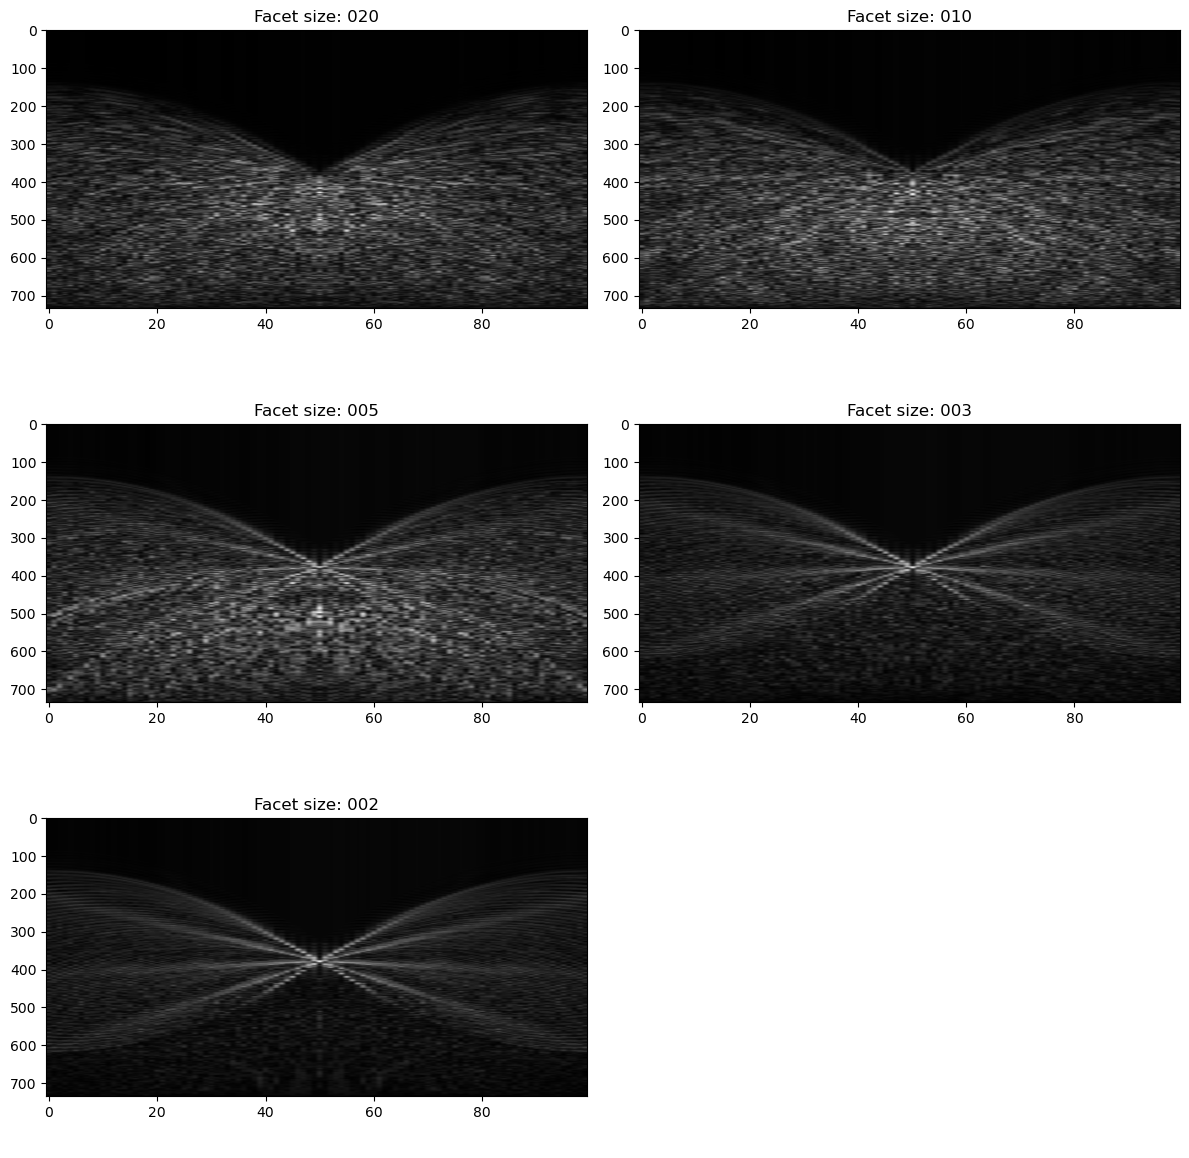

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.flatten()
for i, f in enumerate(focused):
    ax[i].imshow(np.abs(f), cmap="grey", aspect=0.07)
    ax[i].set_title(f"Facet size: {fss[i]:03d}")
ax[-1].axis("off")
plt.tight_layout()
plt.savefig("VariableFsFocused.png")
plt.show()